Problem Set #7

Problem 1:

![alt text](PS7_1.png)



Problem 2: Part A

![alt text](PS7_2a.png)

Problem 2: Part B

starting rsqr is  911698494.0920565


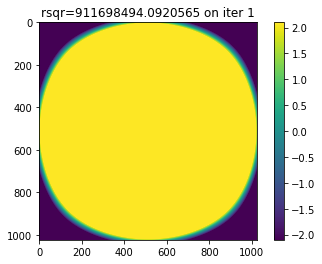

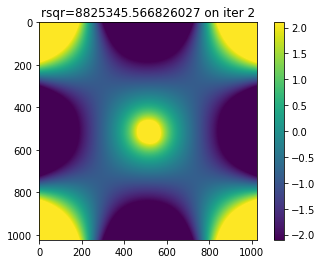

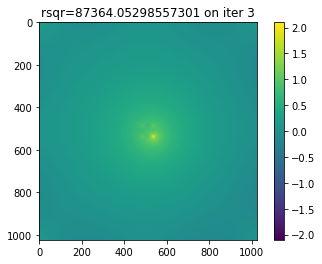

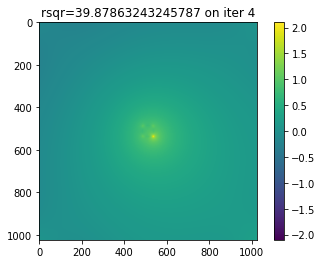

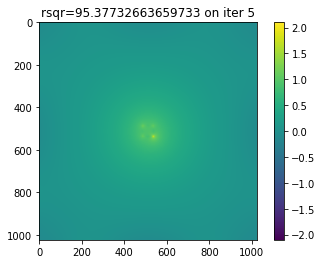

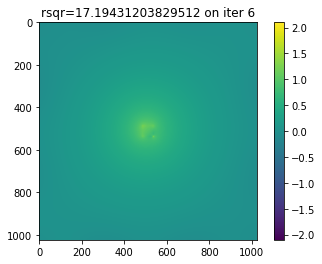

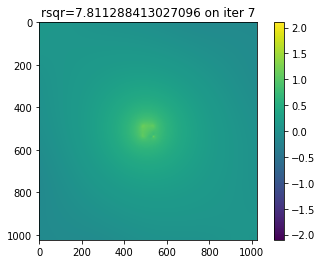

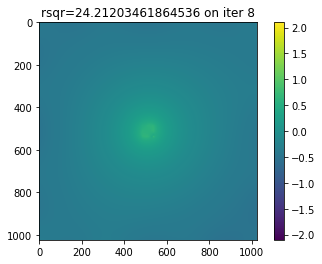

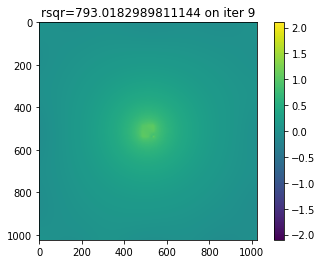

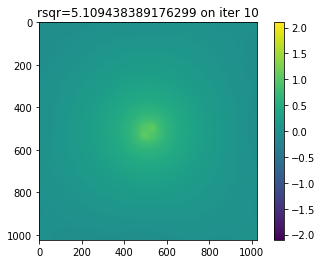

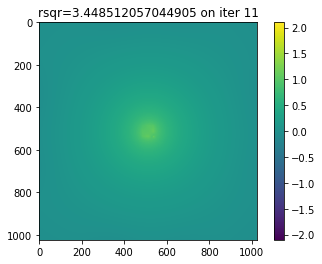

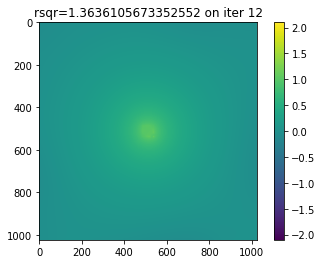

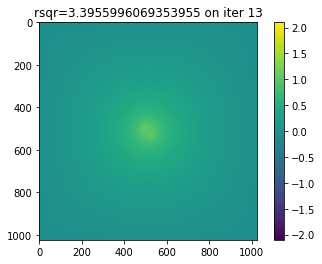

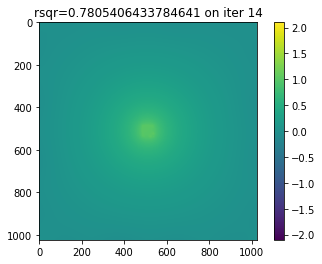

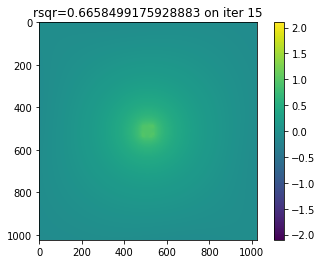

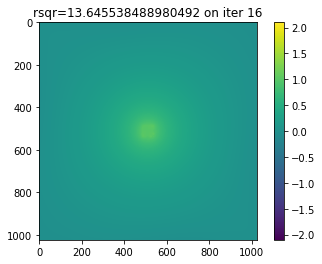

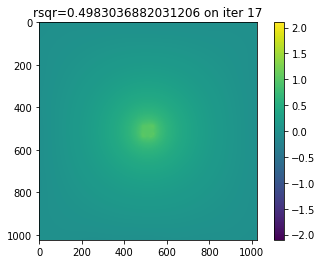

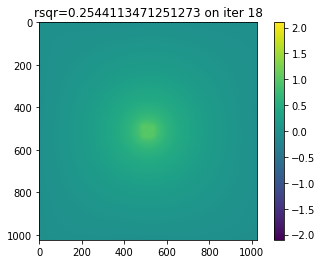

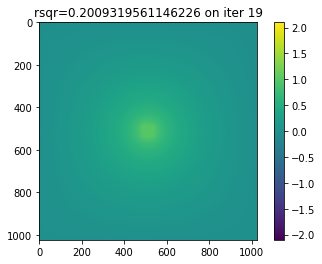

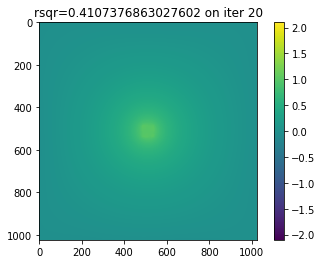

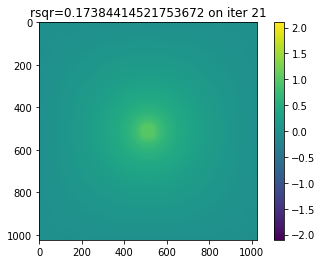

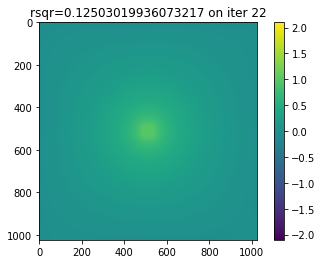

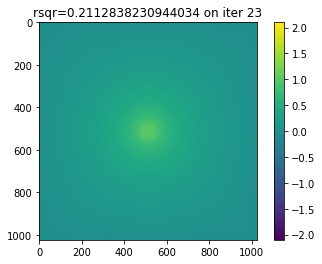

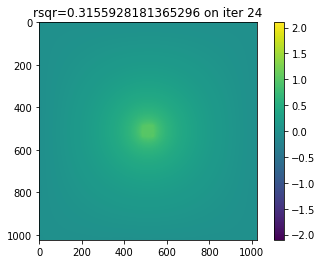

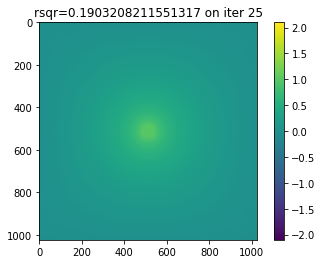

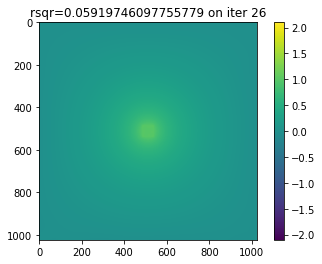

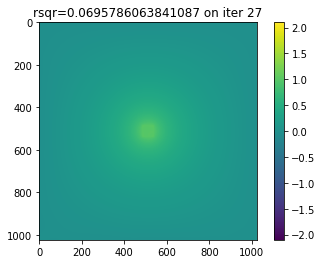

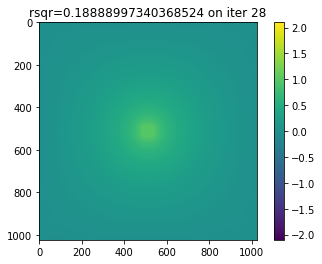

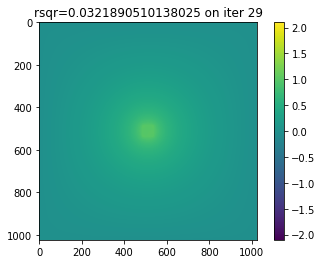

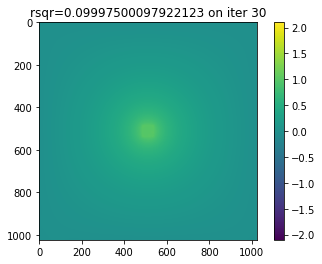

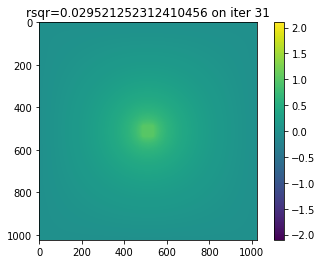

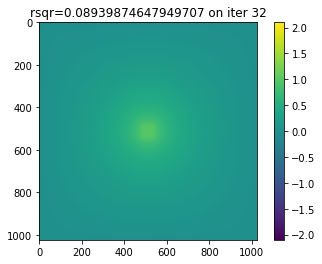

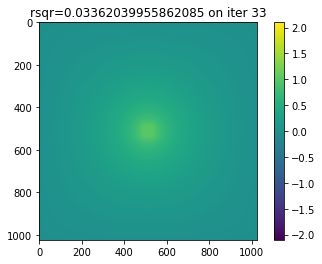

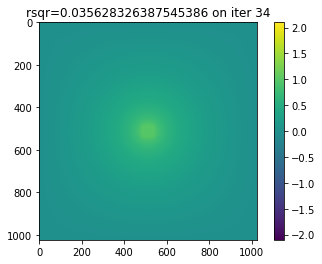

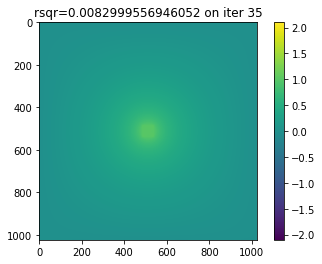

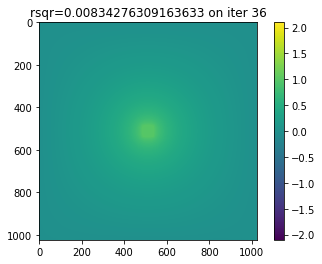

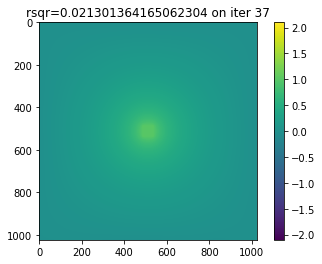

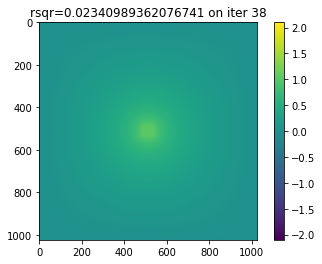

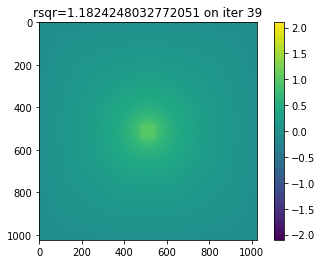

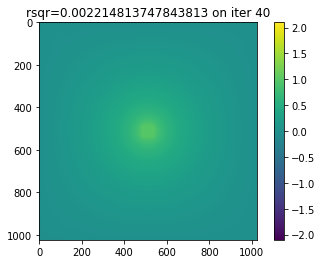

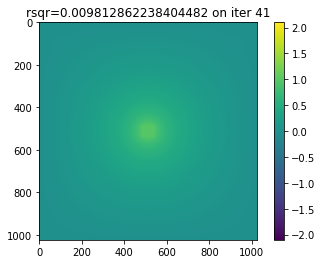

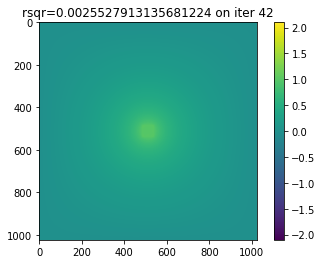

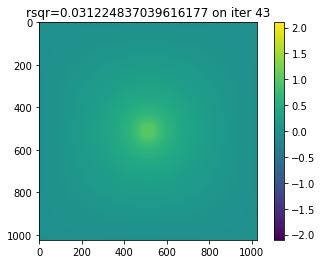

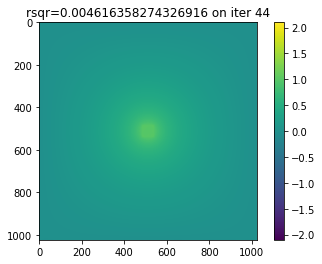

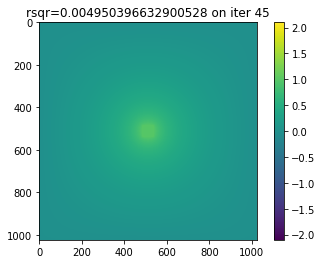

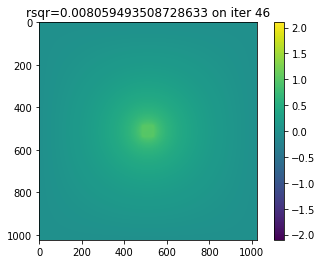

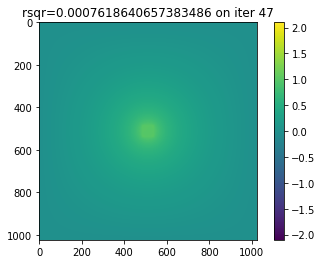

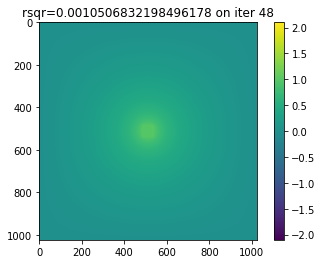

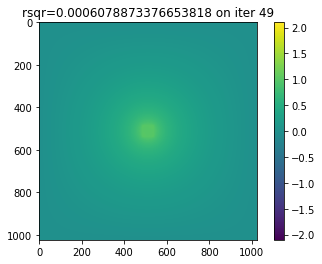

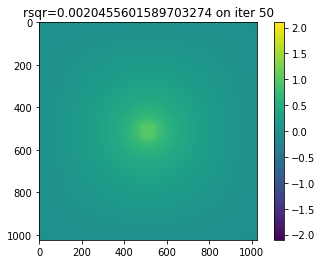

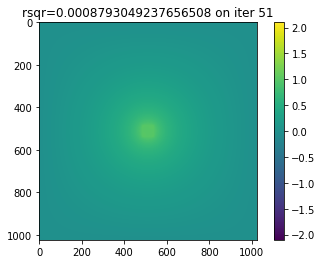

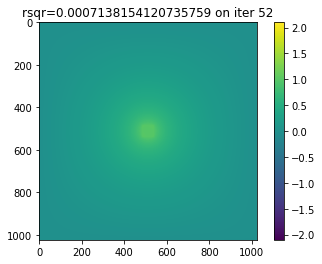

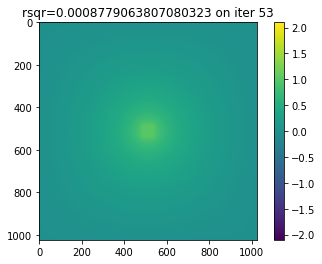

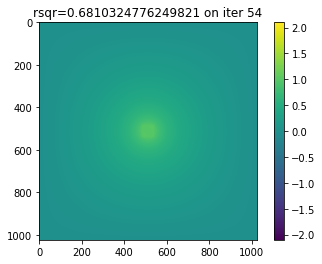

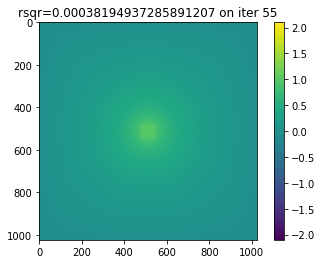

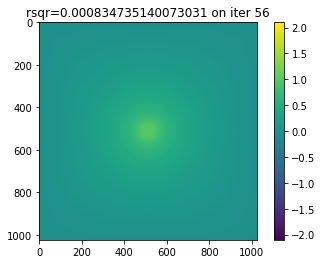

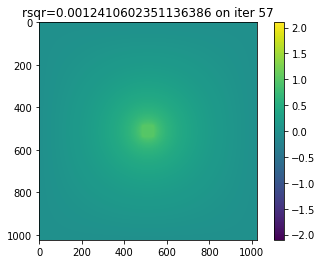

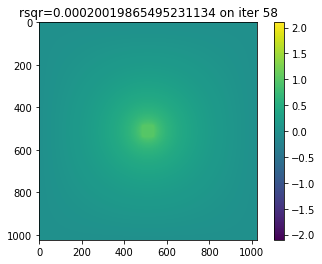

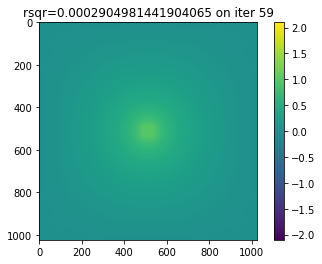

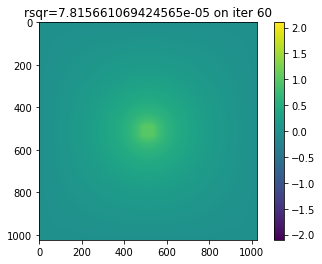

final rsqr is  0.018671765371212554  after  85.72952389717102  seconds


In [187]:
import numpy as np
from matplotlib import pyplot as plt

def greens(n,ndim=2):
    #Get the potential from a single point charge
    dx=np.arange(n)
    dx[n//2:]=dx[n//2:]-n
    xmat,ymat=np.meshgrid(dx,dx)
    dr=np.sqrt(xmat**2+ymat**2)
    dr[0,0]=1 #to avoid errors in pot
    c=1/np.log(4) #see part a
    pot=-c*np.log(dr)
    pot[0,0]=1
    return pot


def rho2pot(rho,kernelft):
    #Convolution
    tmp=rho.copy()
    tmp=np.pad(tmp,(0,tmp.shape[0])) #padding to avoid errors with FT

    tmpft=np.fft.rfftn(tmp)
    tmp=np.fft.irfftn(tmpft*kernelft) #V=rho*G
    tmp=tmp[:rho.shape[0],:rho.shape[1]]
    return tmp #this is now a potential

def rho2pot_masked(rho,mask,kernelft,return_mat=False):
    #Masked Convolution
    rhomat=np.zeros(mask.shape)
    rhomat[mask]=rho #the rho we have is just on the mask
    potmat=rho2pot(rhomat,kernelft)
    if return_mat:
        return potmat
    else:
        return potmat[mask]


def cg(rhs,x0,mask,kernelft,niter,fun=rho2pot_masked,show_steps=False,step_pause=0.01):
    #this runs a conjugate gradient solver to solve Ax=b where A is the Green's function                                                    + convolution as a matrix, and b is the boundary conditions (ie. potential)"
    t1=time.time()
    Ax=fun(x0,mask,kernelft) #convolving rho with G
    r=rhs-Ax #rhs=b=potential
    p=r.copy()
    x=x0.copy() #x=charge
    rsqr=np.sum(r*r)
    print('starting rsqr is ',rsqr)
    for k in range(niter):
        Ap=fun(p,mask,kernelft) #convolving potential with G
        alpha=np.sum(r*r)/np.sum(Ap*p)
        x=x+alpha*p
        if show_steps:  #plot V as we run through          
            tmp=fun(x,mask,kernelft,True) 
            plt.clf();
            plt.imshow(tmp,vmin=-2.1,vmax=2.1)
            plt.colorbar()
            plt.title('rsqr='+repr(rsqr)+' on iter '+repr(k+1))
            plt.pause(step_pause)
        r=r-alpha*Ap
        rsqr_new=np.sum(r*r)
        beta=rsqr_new/rsqr
        p=r+beta*p
        rsqr=rsqr_new
    t2=time.time()
    print('final rsqr is ',rsqr,' after ',t2-t1,' seconds')
    return x

def get_rhs(pot):
    #Average of neighbors
    tot=0
    ndim=len(pot.shape)
    for dim in range(ndim):
        tot=tot+np.roll(pot,1,dim)
        tot=tot+np.roll(pot,-1,dim)
    return tot/(2*ndim)
def get_rho(pot):
    #Density guess from potential (V-average of neighbors)
    tmp=get_rhs(pot)
    return pot-tmp
plt.ion()


n=1024
bc=np.zeros([n,n])
mask=np.zeros([n,n],dtype='bool')
#Everything should go to zero at edges - If I don't do this, potential increases away from the box, which doesn't make physical sense. 
mask[0,:]=True
mask[-1,:]=True
mask[:,0]=True
mask[:,-1]=True
bc[0,:]=0.0
bc[0,0]=0.0
bc[0,-1]=0.0

#This adds a box in the interior held at V=1
bc[19*n//40:21*n//40,19*n//40]=1.0
bc[19*n//40:21*n//40,21*n//40]=1.0
bc[19*n//40,19*n//40:21*n//40]=1.0
bc[21*n//40,19*n//40:21*n//40]=1.0
mask[19*n//40:21*n//40,19*n//40]=True
mask[19*n//40:21*n//40,21*n//40]=True
mask[19*n//40,19*n//40:21*n//40]=True
mask[21*n//40,19*n//40:21*n//40]=True

#Green's function
kernel=greens(2*n,2)
kernelft=np.fft.rfft2(kernel)

V=bc[mask] #just potential on mask
rhs=V
rho0=get_rho(bc) #first guess for rho
x0=rho0[mask] #just rho on mask

rho_out=cg(rhs,x0,mask,kernelft,60,show_steps=True,step_pause=0.25) #show evolution of solution

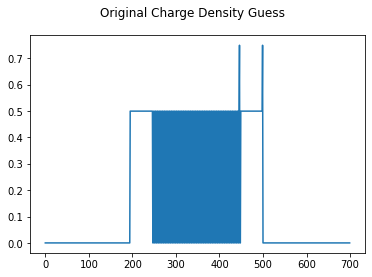

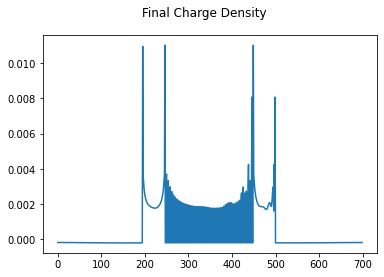

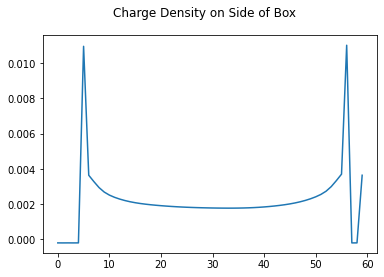

In [212]:

#Plot charge density

#I'm not really sure what the x-axis on rho_out represents/how it lines up with the sides of the box. 

plt.figure(0)
plt.suptitle('Original Charge Density Guess')
plt.plot(x0[1800:2500]) #zoom in on non-zero parts

plt.figure(1)
plt.suptitle("Final Charge Density")
plt.plot(rho_out[1800:2500]) 

plt.figure('side')
plt.suptitle('Charge Density on Side of Box')
plt.plot(rho_out[1990:2050])



In [ ]:
Problem 2: Part C

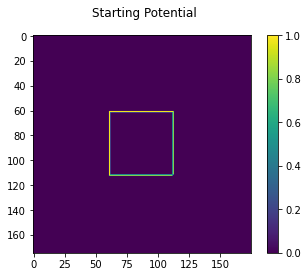

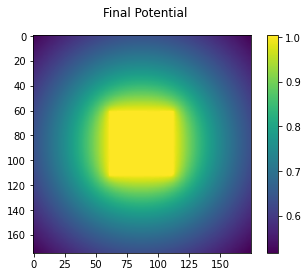

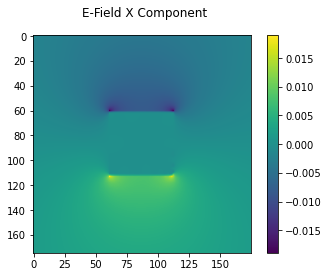

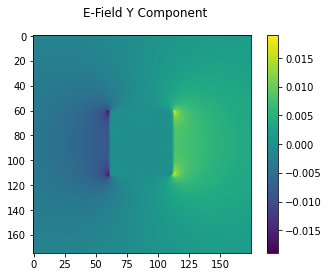

In [213]:
#Make sure potential was set correctly
plt.figure(2)
plt.suptitle("Starting Potential")
plt.imshow(bc[425:600,425:600])
plt.colorbar()

#Get final potential, plot and zoom in on box
pot_out=rho2pot_masked(rho_out,mask,kernelft,True)
plt.figure(3)
plt.suptitle("Final Potential")
plt.imshow(pot_out[425:600,425:600])
plt.colorbar()


#Electric Field - d/dx(V),d/dy(V)
d=1
Vnew=pot_out.copy()
Ex=np.zeros([n,n])
Ey=np.zeros([n,n])
for i in range(n-1):
    Ey[i]=-(Vnew[:,i+d]-Vnew[:,i-d])/2
    Ex[i]=-(Vnew[i+d,:]-Vnew[i-d,:])/2
plt.figure('x')
plt.suptitle("E-Field X Component")
plt.imshow(Ex[425:600,425:600])
plt.colorbar()
plt.figure('y')
plt.suptitle("E-Field Y Component")
plt.imshow(Ey.T[425:600,425:600]) #have to transpose y so that x and y axes match 
plt.colorbar()


The potential is almost completely constant inside the box, as expected. The electric field also matches my expectation. It is concentrated on the corners of the box and zero inside, while also being perpendicular to the sides of the box. At the vertical sides the x-component is zero and at the horizontal sides the y-component is zero. 